# DL-ROM: Deep Learning Reduced Order Modelling

In this notebook, we explore the DL-ROM approach introduced in the paper "Deep Learning for Reduced Order Modelling and Efficient Temporal Evolution of Fluid Simulations" by Pant, Pranshu et al.

DL-ROM leverages neural networks for non-linear projections to reduced order states, facilitating efficient prediction of future simulation time steps. Unlike traditional methods, which utilize linear projections like Proper Orthogonal Decomposition (POD), DL-ROM uses architectures such as 3D Autoencoders and 3D U-Nets. Remarkably, this method achieves accurate reconstructions and future predictions without requiring ground truth supervision or the iterative solution of Navier-Stokes equations, yielding significant computational savings. The technique demonstrates up to two orders of magnitude reduction in computational runtimes of iterative solvers while maintaining an acceptable error threshold.

_Reference:_
> Pant, Pranshu, et al. "Deep learning for reduced order modelling and efficient temporal evolution of fluid simulations." Physics of Fluids 33.10 (2021). [Link](https://github.com/pranshupant/DL-ROM/tree/086b6e8ec43ad378966528bc843ecad148cc26c0)

### Datasets Explored:

In this demonstration, DL-ROM will be applied to the following datasets, each offering different simulation conditions:
1. NOAA - SST: Weekly Mean Sea Surface Temperature.
2. Flow over Plate: Featuring vortex shedding.
3. 2D Cylinder: Highlighting the Von Karman vortex.
4. 2D Square Cylinder: With vortex shedding.
5. Channel Flow: Turbulent flow along a channel. 
6. OpenFOAM: A custom dataset showcasing the Von Karman vortex.

All datasets are 2-dimensional and encompass u-velocity data (X-direction).

In [1]:
import numpy

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import plotly.graph_objects as go


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np
import scipy.io
import h5py
import operator
from functools import reduce
import matplotlib.pyplot as plt
import time
from timeit import default_timer
import scipy
import gdown

output = 'sea_surface_noaa.npy'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    url = 'https://drive.google.com/uc?export=download&id=1THSYqA0B-mVFqmzLSYk1oXus6Kr5uE77'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

sea_surface_noaa.npy already exists, skipping download.


**NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST), Version 2**

The Physical Sciences Division at NOAA provides the NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST) V2 dataset for public access. This rich dataset comes with multiple temporal resolutions: weekly, monthly, and monthly long-term mean data. Intriguingly, the weekly data has variations in its centering, focusing on Wednesdays from 1990-2011 and Sundays from 1981-1989.

For the scope of this research, we've harnessed the weekly data spanning from 1981 to 2011, representing a temporal resolution of 7 days. Pioneering work by Reynolds in 1988 and 1993 guided the bias tuning of the satellite data used. As a result, this dataset is a synthesis of both in-situ observations and satellite data, rendering it both comprehensive and nuanced.

The SST V2 dataset paints a detailed picture of the Sea Surface Temperature, with values expressed in degrees Celsius, spanning across the globe. While it is meticulously curated, one must acknowledge the inherent uncertainties when comparing it to real-world measurements. Each data point is defined on a grid with a spatial resolution of 1-degree latitude by 1-degree longitude, culminating in a layout of 180 x 360 grid points.

In our endeavor to harness the power of neural networks, we have employed 2000 snapshots from this dataset, creating a robust training foundation for our model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def create_and_save_animation(data_file, video_filename="sea_surface_movie.mp4"):
    """
    Create an animation from the NOAA sea surface data and save it as a video.
    
    Parameters:
    - data_file (str): Path to the NOAA sea surface data file (in .npy format).
    - video_filename (str): Name of the output video file (default is "sea_surface_movie.mp4").
    
    Returns:
    - None
    """
    # Load the data
    data = np.load(data_file)
    
    fig, ax = plt.subplots(figsize=(10, 5))

    # Initialize with the first frame
    im = ax.imshow(data[0], animated=True)

    # Remove x and y ticks for better visualization
    ax.axis('off')

    def update(frame):
        im.set_array(data[frame])
        return [im]

    ani = FuncAnimation(fig, update, frames=range(data.shape[0]), blit=True, repeat=False)

    # Save the animation as a video
    ani.save(video_filename, writer='ffmpeg', fps=10)
    
    # Close the figure to prevent it from being displayed
    plt.close(fig)

# Usage example:
create_and_save_animation('sea_surface_noaa.npy')


<video width="640" height="320" controls>
  <source src="./sea_surface_movie.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>

In [3]:
def plot(data):

    fig = go.Figure()

    # Add the initial heatmap
    fig.add_trace(go.Heatmap(z=data[0], colorscale="Viridis", showscale=True))

    # Define the slider
    steps = []
    for i in range(data.shape[0]):
        step = dict(
            args=[{'z': [data[i]]}],
            method="restyle",
            label=str(i)
        )
        steps.append(step)

    sliders = [dict(
        active=0,
        yanchor="top",
        xanchor="left",
        currentvalue={
            "font": {"size": 20},
            "prefix": "Time Step:",
            "visible": True,
            "xanchor": "right"
        },
        pad={"b": 10, "t": 50},
        len=0.9,
        x=0.1,
        y=0,
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders
    )

    fig.show()


## Methodology

![Image Alt Text](https://drive.google.com/uc?export=view&id=1zYJKerjKIs9Ma4TKoDWU9osrvXR1qQet)

In simpler terms, our proposed methodology aims to address the limitations of existing techniques for temporal sequence learning, particularly the drawbacks associated with Long Short-Term Memory (LSTM) networks. LSTMs are not only computationally expensive and time-consuming to train, but they also often overfit and can suffer from problems like exploding gradients.

#### Why 3D Convolutions?
To tackle these issues, we opt for 3D Convolutional Autoencoders. Unlike 2D convolutions, which slide a kernel across two dimensions, 3D convolutions slide across three dimensions. This is particularly useful for handling 4D data, such as a series of 3D images over time, allowing the model to capture both spatial and temporal features. This is critical for applications like weather forecasting or fluid dynamics simulations, where understanding the relationship between different frames (or time-steps) is crucial.

#### Depth-wise Separable Convolutions
Our architecture uses depth-wise separable convolutions, which are computationally more efficient than regular convolutions but still effective for feature extraction. They use fewer parameters, making the model faster and less prone to overfitting.

#### Encoder-Decoder Structure
The architecture consists of an encoder and a decoder. The encoder compresses the input data through a series of 3D convolutional layers followed by BatchNorm and ReLU activations. The compressed features are then flattened to form a feature vector representing the 'reduced state' of the input. This reduced state is subsequently expanded by the decoder to reconstruct the original high-dimensional data. 

#### U-Net Architecture
We further enhance the model by incorporating a U-Net architecture. This enables the model to have shortcut connections between the encoder and decoder, allowing for better localization and feature combination across different layers.

#### Temporal Context
We stack frames (i.e., images from different time-steps) together to form the input. For example, the first input to our model might consist of frames from time steps 0, 10, 20, ..., 90. This stacking helps the model understand the temporal context.

#### Objective Function
Finally, we use Mean Absolute Error (MAE) as our loss function to quantify the difference between the model's predictions and the actual data. This offers a straightforward measure of how well the model is performing.

By combining these elements, our approach efficiently captures spatio-temporal characteristics, making it well-suited for predicting future states in high-order dynamic simulations.

In [36]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from PIL import Image

class AE_3D_Dataset(data.Dataset):
    def __init__(self, input, name='2d_cylinder', transform=None):
        # if name == 'SST':
        #     input = input[:,10:-10,20:-20]

        self.input = input[:-10]
        self.target = input[10:]
        self.transform = transform
        self.hashmap = {i:range(i, i+100, 10) for i in range(self.input.shape[0] - 100)}
        print(len(self.hashmap))

    def __len__(self):
        return len(self.hashmap)

    def __getitem__(self, index):
        idx = self.hashmap[index]
        # print(idx)
        idy = self.hashmap[index]
        ip=self.input[idx]
        op=self.target[idy]

        x=self.transform(ip)
        x=x.permute(1, 2, 0)
        x=x.unsqueeze(0)

        y=self.transform(op)
        y=y.permute(1, 2, 0)
        y=y.unsqueeze(0)
        return x,y

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_kernel_size=[2,2,2]):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(pool_kernel_size, stride=pool_kernel_size)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        x = self.upconv(x)
        
        # Resize x to have the same spatial dimensions as skip, if they are not the same
        if x.shape[-3:] != skip.shape[-3:]:
            spatial_dims = skip.shape[-3:]
            x = F.interpolate(x, size=spatial_dims, mode='trilinear', align_corners=True)
        
        x = torch.cat([x, skip], dim=1)  # Concatenating along the channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x



class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = EncoderBlock(1, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256, pool_kernel_size=[1,2,2])
        
        # Decoder (stays the same as your original code)
        self.dec3 = DecoderBlock(256, 128, 128)  # 256 (input channels), 128 (output channels), 128 (skip channels)
        self.dec2 = DecoderBlock(128, 64, 64)
        self.dec1 = DecoderBlock(64, 64, 1)

        
        # Final Output
        self.out_conv = nn.Conv3d(64, 1, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        
        dec3 = self.dec3(enc3, enc2)
        dec2 = self.dec2(dec3, enc1)
        dec1 = self.dec1(dec2, x)
        
        out = self.out_conv(dec1)
        return out


In [43]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Your UNet3D and AE_3D_Dataset definition here

data = np.load('sea_surface_noaa.npy')

# Train-test split
data_train = data[0:1500]
data_test = data[1500:]

# Transform
transform = transforms.Compose([transforms.ToTensor()])

# Dataset
dataset_train = AE_3D_Dataset(data_train, name='SST', transform=transform)
dataset_test = AE_3D_Dataset(data_test, name='SST', transform=transform)

# Create a validation split
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size
dataset_train, dataset_val = random_split(dataset_train, [train_size, val_size])

# Dataloader
batch_size = 1
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model
model = UNet3D()

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_parameters(model)
print(f'The model has {n_params} trainable parameters.')

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Epochs
epochs = 1

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Training loss: {running_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Validation loss: {val_loss / len(val_loader)}')


1390
437
The model has 5674049 trainable parameters.
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])
torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])


KeyboardInterrupt: 

torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])


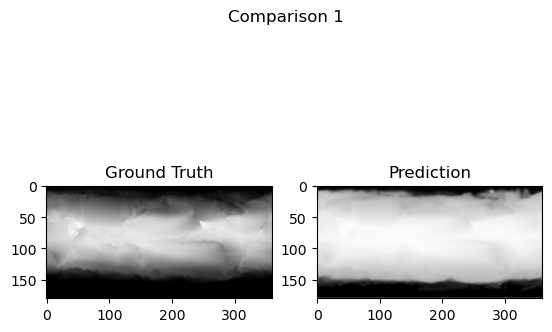

In [44]:
import matplotlib.pyplot as plt

# ... (your training and evaluation loops)

# Evaluation and visualization phase after all epochs are finished
model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        outputs = model(inputs)
        
        # Assuming the data is in shape (batch_size, 1, depth, height, width)
        # And only picking up the first sample in the batch for visualization
        ground_truth_slice = targets[0, 0, targets.shape[2]//2].cpu().numpy()
        predicted_slice = outputs[0, 0, outputs.shape[2]//2].cpu().numpy()
        
        # Plot ground truth and prediction side by side
        fig, axes = plt.subplots(1, 2)
        fig.suptitle(f'Comparison {i+1}')
        axes[0].imshow(ground_truth_slice, cmap='gray')
        axes[0].set_title('Ground Truth')
        
        axes[1].imshow(predicted_slice, cmap='gray')
        axes[1].set_title('Prediction')
        
        plt.show()

        # Stop after first batch for demonstration; remove to visualize all batches
        break


torch.Size([1, 128, 2, 45, 90]) torch.Size([1, 256, 2, 22, 45])


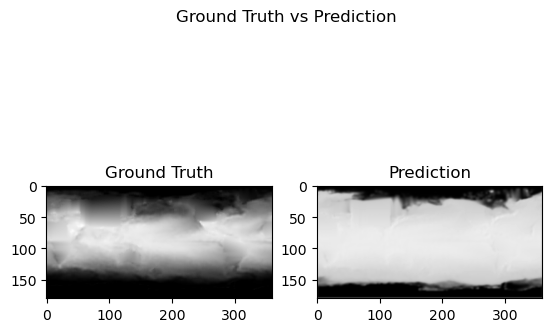

In [51]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch

# ... (your training and evaluation loops)

# Evaluation and visualization phase after all epochs are finished
model.eval()

# Initialize figure
fig, axes = plt.subplots(1, 2)
fig.suptitle('Ground Truth vs Prediction')
im0 = axes[0].imshow(np.zeros((180, 360)), animated=True, cmap='gray')
im1 = axes[1].imshow(np.zeros((180, 360)), animated=True, cmap='gray')
axes[0].set_title('Ground Truth')
axes[1].set_title('Prediction')

ims = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):  # Replace 'dataloader' with your test dataloader
        outputs = model(inputs)
        
        # Convert the tensor to CPU and detach it from the computation graph
        outputs_cpu = outputs[0, 0].cpu().detach().numpy()
        targets_cpu = targets[0, 0].cpu().detach().numpy()
        
        for j in range(outputs_cpu.shape[0]):  # Iterate through the depth
            im0 = axes[0].imshow(targets_cpu[j], animated=True, cmap='gray')
            im1 = axes[1].imshow(outputs_cpu[j], animated=True, cmap='gray')
            ims.append([im0, im1])
        
        # Stop after first batch for demonstration; remove this to animate all batches
        break

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)

# Save the animation
ani.save('ground_truth_vs_prediction.mp4',writer='ffmpeg', fps=3)

plt.show()


<video width="640" height="320" controls>
  <source src="./ground_truth_vs_prediction.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>